# Introduction

## Objectives

## Installs

In [1]:
# Install pdpbox

# Install alepython

# Install eli5

# Install shap

# Install lime

# Install anchor

# Install alibi

## Imports

In [2]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# Interpretability
from pdpbox import pdp
from alepython import ale_plot
from sklearn.inspection import permutation_importance
from eli5.sklearn import PermutationImportance
from eli5 import show_weights
import shap
from lime.lime_tabular import LimeTabularExplainer
from anchor.anchor_tabular import AnchorTabularExplainer
import alibi

# Utils
from utils import plot_distributions, plot_vars_vs_target

## References

https://github.com/SauceCat/PDPbox (in sandbox)  
https://github.com/AustinRochford/PyCEbox  
https://github.com/blent-ai/ALEPython  
https://github.com/slundberg/shap (in sandbox)   
https://github.com/marcotcr/lime (in sandbox)  
https://github.com/marcotcr/lime-experiments  
https://github.com/marcotcr/anchor  
https://github.com/marcotcr/anchor-experiments  

# Data

We are going to use **Bike Sharing Dataset**(https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset) to ilustrate the different methods we have studied. This dataset contains the daily count of rental bikes between years 2011 and 2012 in Capital Bikeshare System in Washington DC with the corresponding weather and seasonal information. We are using this dataset because it contains both numerical and categorical features, so we can show many different examples. The results we can obtain from this regression problem are easily extrapolable to a classification problem since these can be modelled as a regression to a probability funciton.

The dataset has the following features:
* **Index**: record index (we will not use it)
* **Date**: date (we will not use it)
* **Season**:
  * 1: Winter
  * 2: Spring
  * 3: Summer
  * 4: Fall
* **Year**: (we will not use it)
  * 0: 2011
  * 1: 2012
* **Month**: month (1 to 12)
* **Holiday**:
  * 0: Not holiday
  * 1: Holiday
* **Weekday**: day of the week (0 to 6), starting on sunday
* **WorkingDay**:
  * 0: Not holiday or weekend
  * 1: Holiday or weekend
* **Weather**:
  * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* **Temperature**: Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39.
* **FeelingTemperature**: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50.
* **Humidity**: Normalized humidity. The values are divided to 100 (max)
* **WindSpeed**: Normalized wind speed. The values are divided to 67 (max)
* **NumCasualUsers**: count of casual users (this value is a proxi for Target, so we will not use it)
* **NumRegisteredUsers**: count of registered users (this value is a proxi for Target, so we will not use it)
* **Target**: count of total rental bikes including both casual and registered

We start by importing the data, and doing some preprocessing

In [3]:
# Import data
df_regression = pd.read_csv('data/bike_sharing_day.csv')

# Rename columns
df_regression.columns = ['Index',
                         'Date',
                         'Season',
                         'Year', 
                         'Month',
                         'Holiday', 
                         'Weekday', 
                         'WorkingDay',
                         'Weather',
                         'Temperature',
                         'FeelingTemperature',
                         'Humidity',
                         'WindSpeed',
                         'NumCasualUsers',
                         'NumRegisteredUsers',
                         'Target']

# Process the variables
df_regression = df_regression.drop(['Index','Year','Date','NumCasualUsers','NumRegisteredUsers'], axis = 1)
df_regression['Temperature'] = df_regression['Temperature'] * (39 - (-8)) + (-8)
df_regression['FeelingTemperature'] = df_regression['FeelingTemperature'] * (50 - (-16)) + (-16)
df_regression['Humidity'] = df_regression['Humidity'] * 100
df_regression['WindSpeed'] = df_regression['WindSpeed'] * 67
df_regression['Weekday'] = (df_regression['Weekday'] + 6) % 7

# Create dictionaries with the labels of the categorical variables
dict_Season = {
    1 : 'Winter',
    2 : 'Spring',
    3 : 'Summer',
    4 : 'Fall'
    }

dict_Weather = {
    1 : 'Sunny',
    2 : 'Cloudy',
    3 : 'LightRain',
    4 : 'HeavyRain'
    }

dict_labels = {
    'Season'  : dict_Season,
    'Weather' : dict_Weather
    }

for var in dict_labels.keys():
    df_regression[var] = df_regression[var].map(dict_labels[var])


# Correct the types
df_regression = df_regression.astype({'Season'     : 'category',
                                      'Weather'    : 'category',
                                      })

then take a look at the variables

In [4]:
df_regression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Season              731 non-null    category
 1   Month               731 non-null    int64   
 2   Holiday             731 non-null    int64   
 3   Weekday             731 non-null    int64   
 4   WorkingDay          731 non-null    int64   
 5   Weather             731 non-null    category
 6   Temperature         731 non-null    float64 
 7   FeelingTemperature  731 non-null    float64 
 8   Humidity            731 non-null    float64 
 9   WindSpeed           731 non-null    float64 
 10  Target              731 non-null    int64   
dtypes: category(2), float64(4), int64(5)
memory usage: 53.2 KB


and to some samples of data

In [5]:
df_regression.head()

Season  Month  Holiday  Weekday  WorkingDay Weather  Temperature  \
0  Winter      1        0        5           0  Cloudy     8.175849   
1  Winter      1        0        6           0  Cloudy     9.083466   
2  Winter      1        0        0           1   Sunny     1.229108   
3  Winter      1        0        1           1   Sunny     1.400000   
4  Winter      1        0        2           1   Sunny     2.666979   

   FeelingTemperature  Humidity  WindSpeed  Target  
0            7.999250   80.5833  10.749882     985  
1            7.346774   69.6087  16.652113     801  
2           -3.499270   43.7273  16.636703    1349  
3           -1.999948   59.0435  10.739832    1562  
4           -0.868180   43.6957  12.522300    1600

so we can plot the distribution of the variables

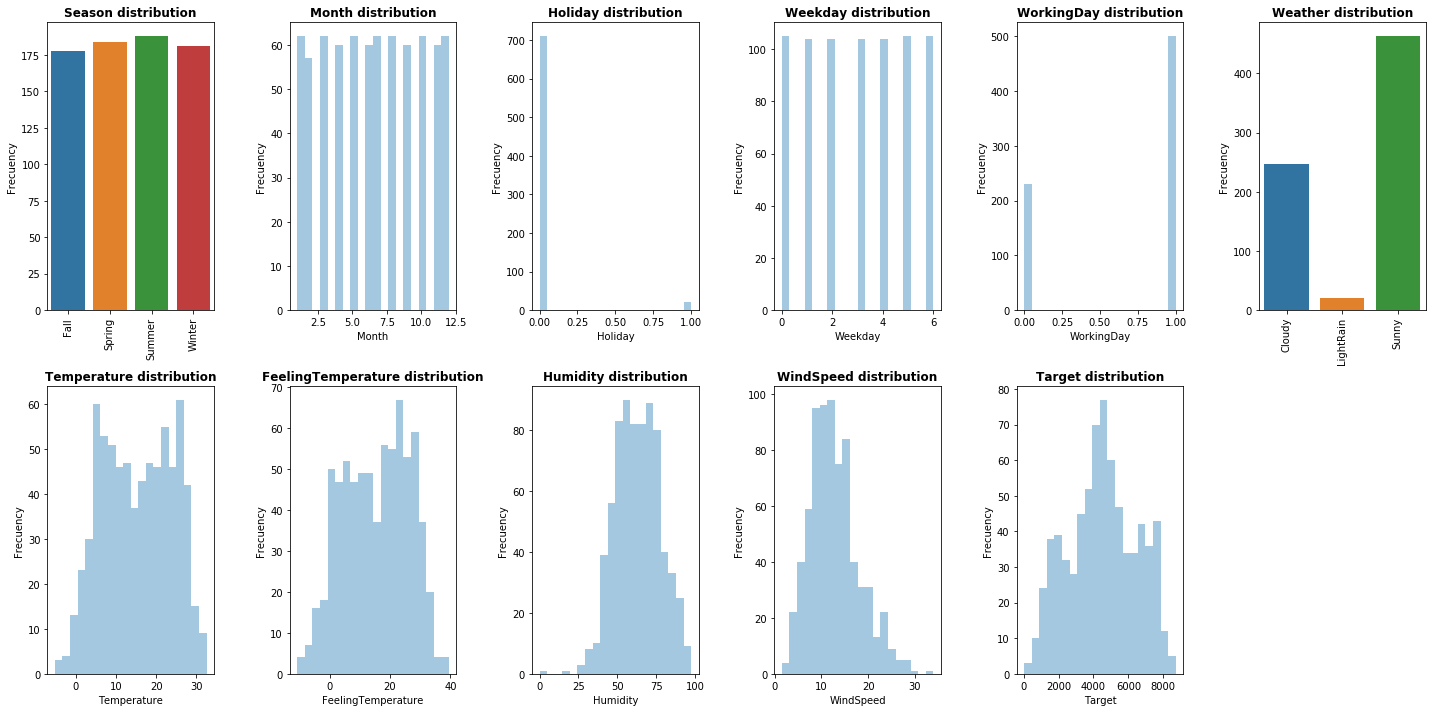

In [6]:
fig = plot_distributions(df_regression, n_cols = 6)
# fig.savefig('plot_distributions.png')

and a plot vs. the target variable

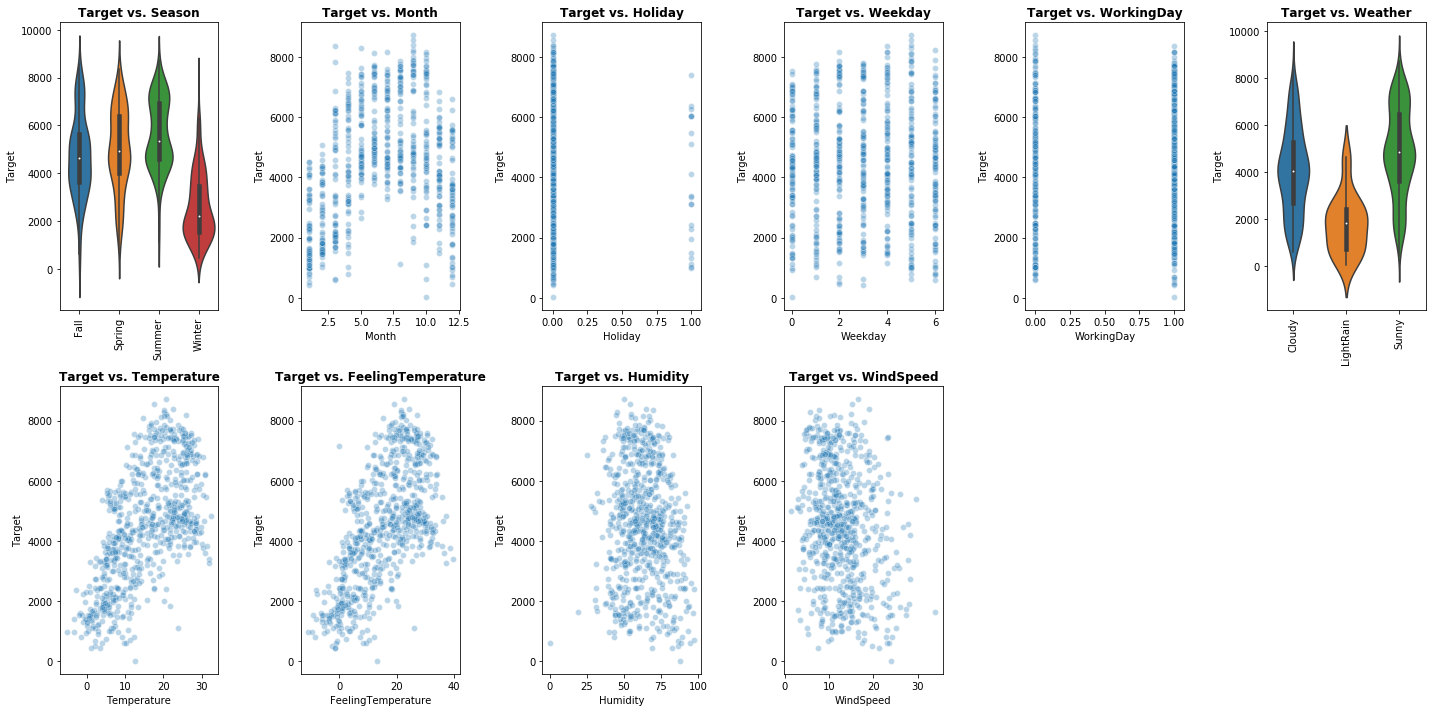

In [7]:
fig = plot_vars_vs_target(df_regression, n_cols = 6)
# fig.savefig('plot_targetplot.png')

# Modelling

In [8]:
# Prepare the data for the model
X = df_regression.drop('Target', axis = 1).copy()
y = df_regression['Target'].copy()
    
# Save the original features
features = X.columns.tolist()
    
# Get dummies for categorical variables
if dict_labels:
    for var in dict_labels.keys():
        X_var = pd.get_dummies(X[var], prefix = var, prefix_sep = '_')
        X = X.drop(var, axis = 1)
        X = pd.concat([X, X_var], axis = 1)

# Create a train set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Interpretable models

### Linear models

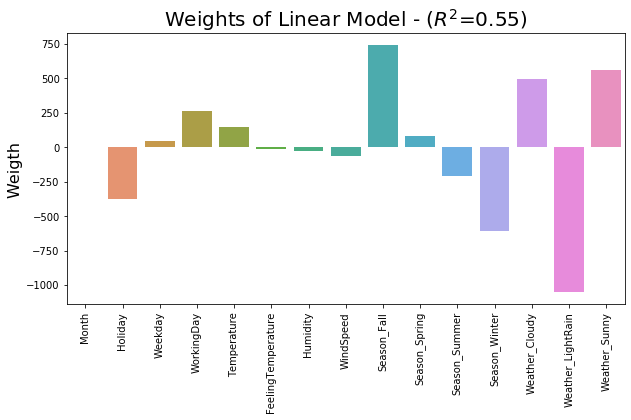

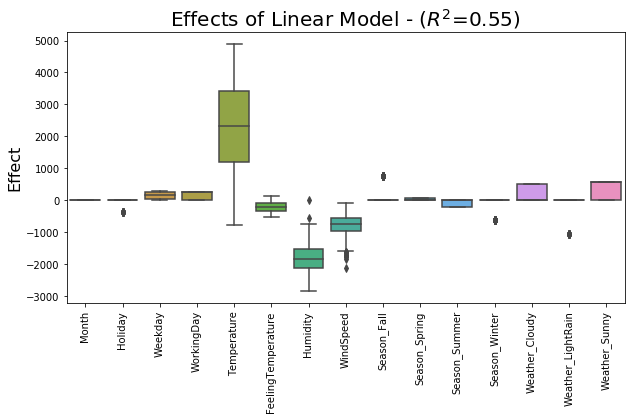

In [9]:
# Initiate and train the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Compute weights
df_weights = pd.DataFrame({'Feature' : X.columns, 'Weight' : lr.coef_})

# Compute effects
df_effects = np.multiply(X, df_weights.iloc[:,1])

# Plot weights
plt.figure(figsize = (10, 5))
sns.barplot(x = 'Feature', y = 'Weight', data = df_weights)
plt.title('Weights of Linear Model - ($R^2$={:.2f})'.format(lr.score(X_test, y_test)), fontsize = 20)
plt.xlabel('')
plt.ylabel('Weigth', fontsize = 16)
plt.xticks(rotation = 90)
plt.show()

# Plot effects
plt.figure(figsize = (10, 5))
sns.boxplot(data = df_effects)
plt.title('Effects of Linear Model - ($R^2$={:.2f})'.format(lr.score(X_test, y_test)), fontsize = 20)
plt.xlabel('', fontsize = 16)
plt.ylabel('Effect', fontsize = 16)
plt.xticks(rotation = 90)
plt.show()

### Tree models

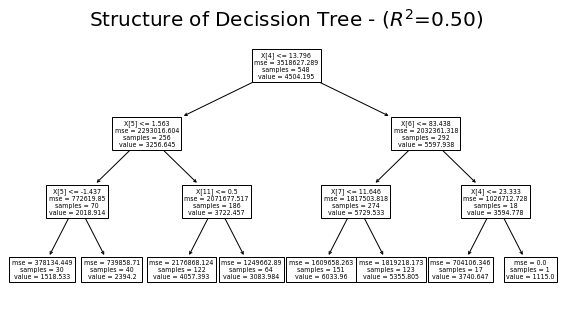

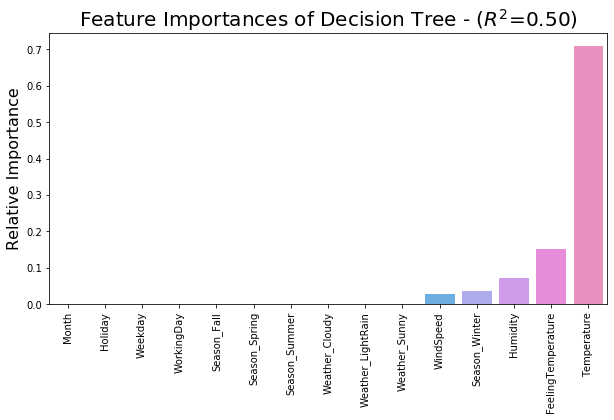

In [10]:
# Initiate and train the model
dtr = DecisionTreeRegressor(max_depth = 3)
dtr.fit(X_train, y_train)

# Compute importances
df_importances = pd.DataFrame({'Feature' : X.columns, 'Importance' : dtr.feature_importances_})
df_importances = df_importances.sort_values(by = 'Importance')

# Plot structure
plt.figure(figsize = (10, 5))
plot_tree(dtr)
plt.title('Structure of Decission Tree - ($R^2$={:.2f})'.format(dtr.score(X_test, y_test)), fontsize = 20)
plt.show()

# Plot importances
plt.figure(figsize = (10, 5))
sns.barplot(x = 'Feature', y = 'Importance', data = df_importances)
plt.title('Feature Importances of Decision Tree - ($R^2$={:.2f})'.format(dtr.score(X_test, y_test)), fontsize = 20)
plt.xlabel('', fontsize = 16)
plt.ylabel('Relative Importance', fontsize = 16)
plt.xticks(rotation = 90)
plt.show()

## Non-interpretable models

### Ranfom Forest

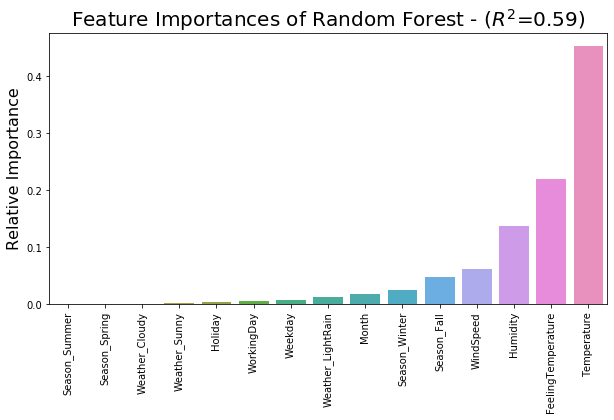

In [11]:
# Initiate and train the model
rfr = RandomForestRegressor(n_estimators = 50, max_depth = 5)
rfr.fit(X_train, y_train)

# Compute importances
df_importances = pd.DataFrame({'Feature' : X.columns, 'Importance' : rfr.feature_importances_})
df_importances = df_importances.sort_values(by = 'Importance')

# Plot importances
plt.figure(figsize = (10, 5))
sns.barplot(x = 'Feature', y = 'Importance', data = df_importances)
plt.title('Feature Importances of Random Forest - ($R^2$={:.2f})'.format(rfr.score(X_test, y_test)), fontsize = 20)
plt.xlabel('', fontsize = 16)
plt.ylabel('Relative Importance', fontsize = 16)
plt.xticks(rotation = 90)
plt.show()

# Interpretability

## Partial Dependence Plots (PDP)

This library works in such a way that first we have to compute the partial dependences, using:
* **pdpbox.pdp.pdp_isolate**: compute partial dependences for PDP.
    * *model*: a fitted sklearn model.
    * *dataset*: pandas DataFrame. Data set on which the model is trained
    * *model_features*: list or 1-d array. List of model features.
    * *feature*: string or list. Feature or feature list to investigate, for one-hot encoding features, feature list is required
    * *num_grid_points*: integer. Number of grid points for numeric feature, default=10.
    * *grid_type*: string. T, ‘percentile’ or ‘equal’ype of grid points for numeric feature, ‘percentile’ or ‘equal’, default=’percentile’.
* **pdpbox.pdp.pdp_interact**: compute partial dependences, with two features, for PDP.
    * *model*: a fitted sklearn model.
    * *dataset*: pandas DataFrame. Data set on which the model is trained.
    * *model_features*: list or 1-d array. List of model features.
    * *features*: list. [feature1, feature2].
    * *num_grid_points*: list. [feature1 num_grid_points, feature2 num_grid_points].
    * grid_types: list. [feature1 grid_type, feature2 grid_type].

and then we can make the PDP, using:
* **pdpbox.pdp.pdp_plot**: plot partial dependent plot.
    * *pdp_isolate_out*: instance of PDPIsolate.
    * *feature_name*: string. Name of the feature, not necessary a column name.
    * *center*: bool. Whether to center the plot, default=True.
    * *plot_pts_dist*: bool. Whether to show data points distribution, default=False.
    * *plot_lines*: bool. Whether to plot out the individual lines, default=False.
    * *frac_to_plot*: float or integer. How many lines to plot, can be a integer or a float, default=1.
    * *x_quantile*: bool. Whether to construct x axis ticks using quantiles, default=False.
    * *show_percentile*: bool. Whether to display the percentile buckets, for numeric feature when grid_type=’percentile’, default=False.
* **pdpbox.pdp.pdp_interact_plot**: plot interact plot, that is, partial dependence plot with two features.
    * *pdp_interact_out*: instance of PDPInteract.
    * *feature_names*: list. [feature_name1, feature_name2]
    * *plot_type*: str. Type of the interact plot, can be ‘contour’ or ‘grid’, default=’contour’.
    * *x_quantile*: bool. Whether to construct x axis ticks using quantiles, default=False.
    * *plot_pdp*: bool. Whether to plot pdp for each feature, default=False.

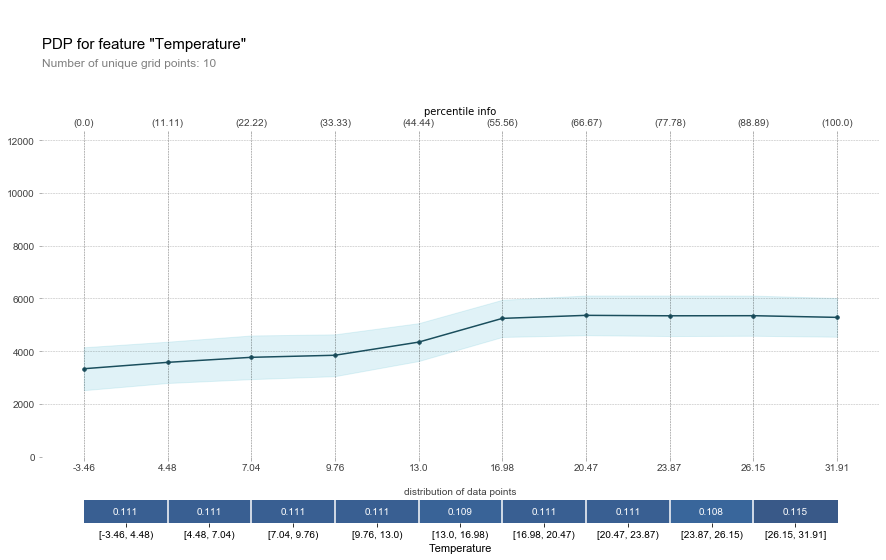

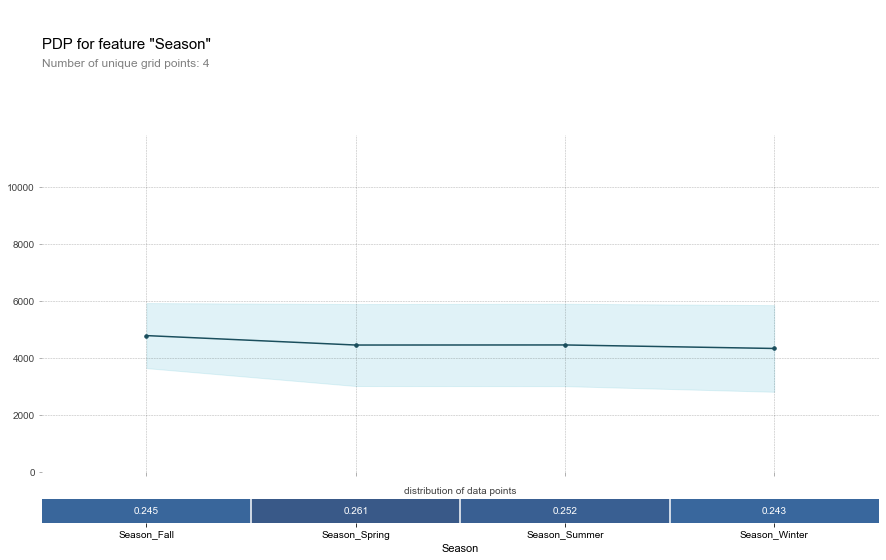

In [12]:
# Numerical variable
pdp_Temperature = pdp.pdp_isolate(model = rfr,
                                  dataset = X_train,
                                  model_features = X_train.columns.tolist(),
                                  feature = 'Temperature'
                                  )
fig, axes = pdp.pdp_plot(pdp_isolate_out = pdp_Temperature,
                         feature_name = 'Temperature',
                         center = False,
                         plot_lines = False,
                         plot_pts_dist = True,
                         x_quantile = True,
                         show_percentile = True
                         )
plt.show()

# Categorical variable
pdp_Season = pdp.pdp_isolate(model = rfr, 
                             dataset = X_train, 
                             model_features = X_train.columns.tolist(), 
                             feature = [var for var in X_train.columns.tolist() if 'Season' in var]
                             )
fig, axes = pdp.pdp_plot(pdp_isolate_out = pdp_Season,
                         feature_name = 'Season',
                         center = False,
                         plot_lines = False,
                         plot_pts_dist = True
                         )
plt.show()

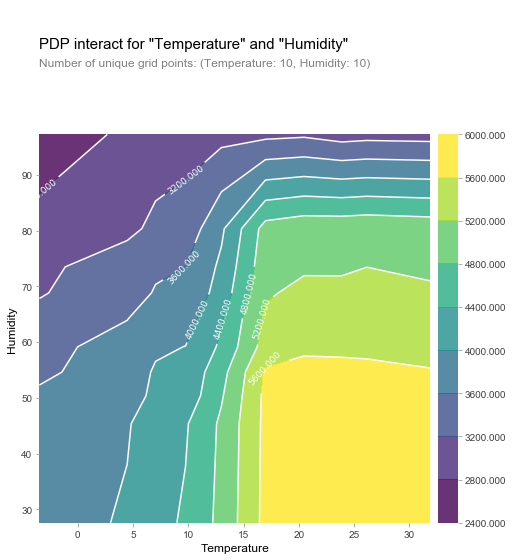

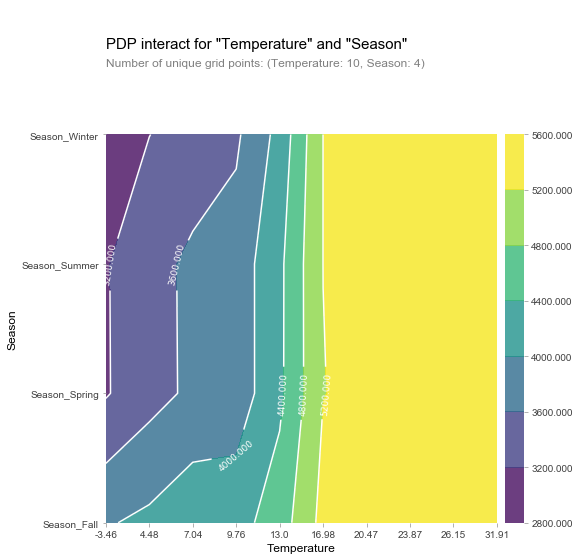

In [13]:
# Numerical variable
pdp_interaction = pdp.pdp_interact(model = rfr,
                                   dataset = X_train,
                                   model_features = X_train.columns.tolist(),
                                   features = ['Temperature','Humidity']
                                   )
fig, axes = pdp.pdp_interact_plot(pdp_interact_out = pdp_interaction,
                                  feature_names = ['Temperature','Humidity'],
                                  x_quantile = False,
                                  plot_pdp = False,
                                  plot_type = 'contour'
                                  )
plt.show()

# Categorical variable
pdp_interaction = pdp.pdp_interact(model = rfr,
                                   dataset = X_train,
                                   model_features = X_train.columns.tolist(),
                                   features = ['Temperature', [var for var in X_train.columns.tolist() if 'Season' in var]]
                                   )
fig, axes = pdp.pdp_interact_plot(pdp_interact_out = pdp_interaction,
                                  feature_names = ['Temperature','Season'],
                                  x_quantile = True,
                                  plot_pdp = False,
                                  plot_type = 'contour'
                                  )
plt.show()

## Independent Conditional Explanation (ICE)

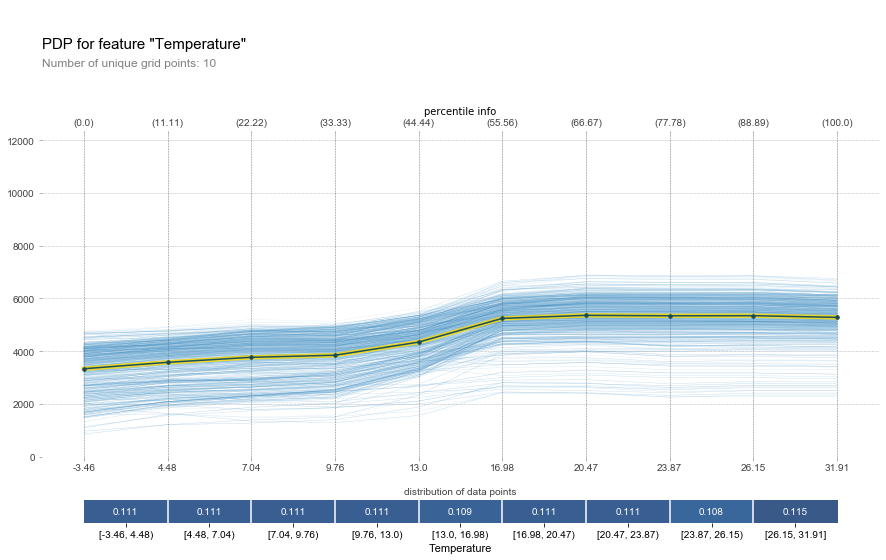

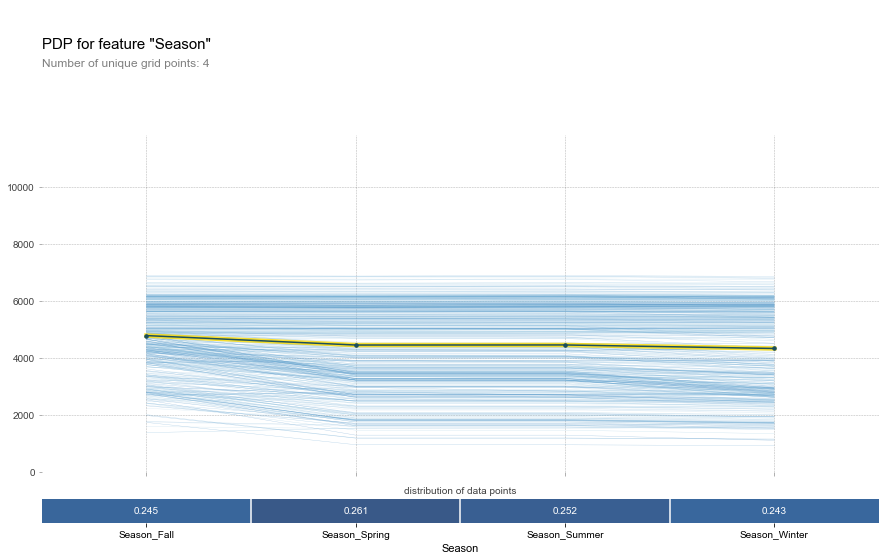

In [14]:
# Numerical variable
pdp_Temperature = pdp.pdp_isolate(model = rfr,
                                  dataset = X_train,
                                  model_features = X_train.columns.tolist(),
                                  feature = 'Temperature'
                                  )
fig, axes = pdp.pdp_plot(pdp_isolate_out = pdp_Temperature, 
                         feature_name = 'Temperature', 
                         center = False,
                         plot_lines = True,
                         plot_pts_dist = True,
                         x_quantile = True,
                         show_percentile = True
                         )
plt.show()

# Categorical variable
pdp_Season = pdp.pdp_isolate(model = rfr, 
                             dataset = X_train, 
                             model_features = X_train.columns.tolist(), 
                             feature = [var for var in X_train.columns.tolist() if 'Season' in var]
                             )
fig, axes = pdp.pdp_plot(pdp_isolate_out = pdp_Season, 
                         feature_name = 'Season',
                         center = False,
                         plot_lines = True,
                         plot_pts_dist = True
                         )
plt.show()

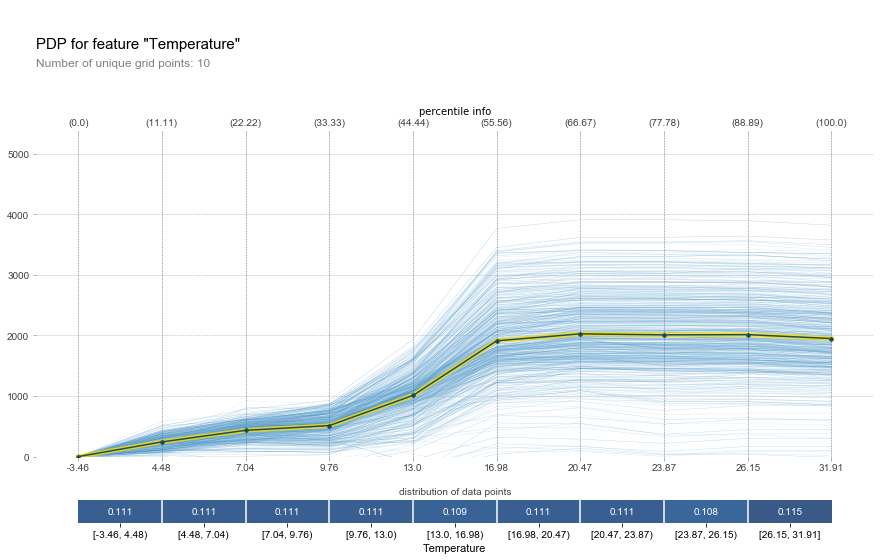

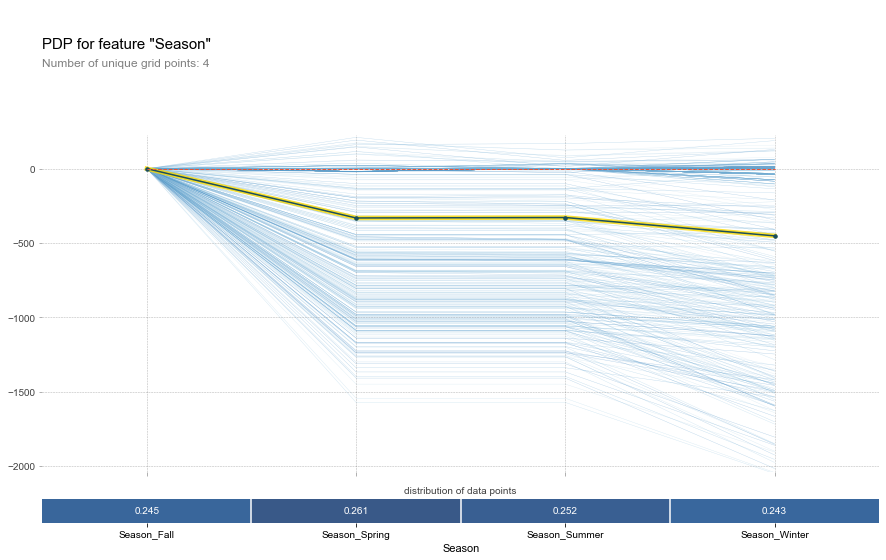

In [15]:
# Numerical variable
fig, axes = pdp.pdp_plot(pdp_isolate_out = pdp_Temperature, 
                         feature_name = 'Temperature', 
                         center = True,
                         plot_lines = True,
                         plot_pts_dist = True,
                         x_quantile = True,
                         show_percentile = True
                         )
plt.show()

# Categorical variable
fig, axes = pdp.pdp_plot(pdp_isolate_out = pdp_Season, 
                         feature_name = 'Season',
                         center = True,
                         plot_lines = True,
                         plot_pts_dist = True
                         )
plt.show()

## Accumulated Local Effects (ALE)

This library has only one function:
* **ale_plot**: Plots ALE function of specified features based on training set.
    * *model*: object. An object that implements a 'predict' method. If None, a `predictor` function must be supplied which will be used instead of `model.predict`.
    * *train_set*: pandas.core.frame.DataFrame. Training set on which model was trained.
    * *features*: [2-iterable of] column label. One or two features for which to plot the ALE plot.
    * *bins*: [2-iterable of] int. Number of bins used to split feature's space. 2 integers can only be given when 2 features are supplied in order to compute a different number of quantiles for each feature.
    * *monte_carlo*: boolean. Compute and plot Monte-Carlo samples.
    * *predictor*: callable. Custom prediction function. See `model`.
    * *features_classes*: iterable of str. If features is first-order and a categorical variable, plot ALE according to discrete aspect of data.
    * *monte_carlo_rep*: int. Number of Monte-Carlo replicas.
    * *monte_carlo_ratio*: float. Proportion of randomly selected samples from dataset for each Monte-Carlo replica.
    * *rugplot_lim*: int. If `train_set` has more rows than `rugplot_lim`, no rug plot will be plotted. Set to None to always plot rug plots. Set to 0 to always plot rug plots.

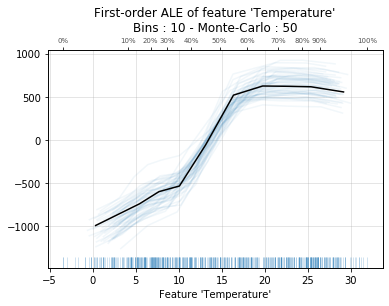

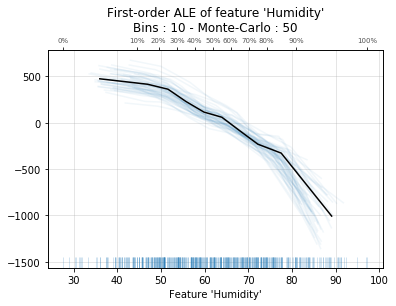

In [16]:
# Numerical variable
ale_plot(model = rfr, 
         train_set = X_train, 
         features = 'Temperature', 
         bins = 10,
         monte_carlo = True
         )
plt.show()

ale_plot(model = rfr, 
         train_set = X_train, 
         features = 'Humidity', 
         bins = 10,
         monte_carlo = True
         )
plt.show()

# Categorical variable: NOT IMPLEMENTED YET

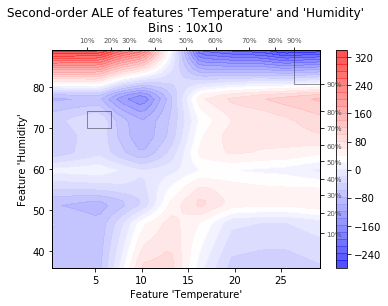

In [17]:
# Numerical variable
ale_plot(model = rfr, 
         train_set = X_train, 
         features = ['Temperature','Humidity'], 
         bins = 10,
         monte_carlo = True
         )
plt.show()

# Categorical variable: NOT IMPLEMENTED YET

## Permutation Feature Importance

The **sklearn** library includes the computation of permutation importance for feature evaluation:
* **sklearn.inspection.permutation_importance**: Permutation importance for feature evaluation. The estimator is required to be a fitted estimator. X can be the data set used to train the estimator or a hold-out set. The permutation importance of a feature is calculated as follows. First, a baseline metric, defined by scoring, is evaluated on a (potentially different) dataset defined by the X. Next, a feature column from the validation set is permuted and the metric is evaluated again. The permutation importance is defined to be the difference between the baseline metric and metric from permutating the feature column.
    * *estimator*: object. An estimator that has already been fitted and is compatible with scorer.
    * *X*: ndarray or DataFrame, shape (n_samples, n_features). Data on which permutation importance will be computed.
    * *y*: array-like or None, shape (n_samples, ) or (n_samples, n_classes). Targets for supervised or None for unsupervised.
    * *scoring*: string, callable or None, default=None. Scorer to use. It can be a single string (see The scoring parameter: defining model evaluation rules) or a callable (see Defining your scoring strategy from metric functions). If None, the estimator’s default scorer is used.
    * *n_repeats*: int, default=5. Number of times to permute a feature.

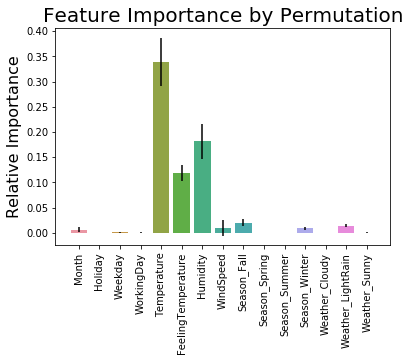

In [18]:
# Compute PFI
pfi = permutation_importance(rfr, 
                             X_test, 
                             y_test,
                             n_repeats = 10,
                             random_state = 0
                             )

# Prepare dataframe 
df_pfi = pd.DataFrame({'Feature'          : X_test.columns, 
                       'importances_mean' : pfi['importances_mean'],
                       'importances_std'  : pfi['importances_std']
                       })

# Make the plot
sns.barplot(x = 'Feature', y = 'importances_mean', data = df_pfi)
plt.errorbar(x = df_pfi['Feature'], 
             y = df_pfi['importances_mean'], 
             yerr = df_pfi['importances_std'],
             color = 'black', 
             linestyle = ''
             )
plt.title('Feature Importance by Permutation', fontsize = 20)
plt.xlabel('')
plt.ylabel('Relative Importance', fontsize = 16)
plt.xticks(rotation = 90)
plt.show()

The **eli5** implements several algorithms for inspecting black-box models. Between them, it includes a module for computing FPI for sklearn models. This module generates this values using the function **eli5.sklearn.PermutationImportance**, which uses the following arguments:
* *estimator* (object): The base estimator. This can be both a fitted (if prefit is set to True) or a non-fitted estimator.
* *scoring* (string, callable or None, default=None): Scoring function to use for computing feature importances. A string with scoring name (see scikit-learn docs) or a scorer callable object / function with signature scorer(estimator, X, y). If None, the score method of the estimator is used.
* *n_iter* (int, default 5): Number of random shuffle iterations. Decrease to improve speed, increase to get more precise estimates.

In [19]:
# Compute PFI
perm = PermutationImportance(rfr, n_iter = 10, random_state=0)
perm = perm.fit(X_test, y_test)

# Make the plot
show_weights(perm, feature_names = X_test.columns.tolist())

## Shapley values

This library includes modules for computing SHAP for various models: 
* *TreeExplainer*: An implementation of Tree SHAP, a fast and exact algorithm to compute SHAP values for trees and ensembles of trees.
* *DeepExplainer*: An implementation of Deep SHAP, a faster (but only approximate) algorithm to compute SHAP values for deep learning models that is based on connections between SHAP and the DeepLIFT algorithm.
* *GradientExplainer*: An implementation of expected gradients to approximate SHAP values for deep learning models. It is based on connections between SHAP and the Integrated Gradients algorithm. GradientExplainer is slower than DeepExplainer and makes different approximation assumptions.
* *LinearExplainer*: For a linear model with independent features we can analytically compute the exact SHAP values. We can also account for feature correlation if we are willing to estimate the feature covaraince matrix. LinearExplainer supports both of these options.
* *KernelExplainer*: An implementation of Kernel SHAP, a model agnostic method to estimate SHAP values for any model. Because it makes not assumptions about the model type, KernelExplainer is slower than the other model type specific algorithms.

We are using *KernelExplainer* by its model-agnosticness. It has the following arguments:
* *model*: function or iml.Model. User supplied function that takes a matrix of samples (# samples x # features) and computes a the output of the model for those samples. The output can be a vector (# samples) or a matrix (# samples x # model outputs).
* *data*: numpy.array or pandas.DataFrame or shap.common.DenseData or any scipy.sparse matrix The background dataset to use for integrating out features. To determine the impact of a feature, that feature is set to “missing” and the change in the model output is observed. Since most models aren’t designed to handle arbitrary missing data at test time, we simulate “missing” by replacing the feature with the values it takes in the background dataset. So if the background dataset is a simple sample of all zeros, then we would approximate a feature being missing by setting it to zero. For small problems this background dataset can be the whole training set, but for larger problems consider using a single reference value or using the kmeans function to summarize the dataset. Note: for sparse case we accept any sparse matrix but convert to lil format for performance.
* *link*: “identity” or “logit”. A generalized linear model link to connect the feature importance values to the model output. Since the feature importance values, phi, sum up to the model output, it often makes sense to connect them to the output with a link function where link(output) = sum(phi). If the model output is a probability then the LogitLink link function makes the feature importance values have log-odds units.

And we can get many different plots:
* **shap.waterfall_plot()**: Plots an explantion of a single prediction as a waterfall plot. The SHAP value of a feature represents the impact of the evidence provided by that feature on the model’s output. The waterfall plot is designed to visually display how the SHAP values (evidence) of each feature move the model output from our prior expectation under the background data distribution, to the final model prediction given the evidence of all the features. Features are sorted by the magnitude of their SHAP values with the smallest magnitude features grouped together at the bottom of the plot when the number of features in the models exceeds the max_display parameter.
    * *shap_values*: Explanation. A one-dimensional Explanation object that contains the feature values and SHAP values to plot.
    * *max_display*: str. The maximum number of features to plot.
    * *show*: bool. Whether matplotlib.pyplot.show() is called before returning. Setting this to False allows the plot to be customized further after it has been created.
* **shap.force_plot**: Visualize the given SHAP values with an additive force layout.
    * *base_value*: float. This is the reference value that the feature contributions start from. For SHAP values it should be the value of explainer.expected_value.
    * *shap_values*: numpy.array. Matrix of SHAP values (# features) or (# samples x # features). If this is a 1D array then a single force plot will be drawn, if it is a 2D array then a stacked force plot will be drawn.
    * *features*: numpy.array. Matrix of feature values (# features) or (# samples x # features). This provides the values of all the features, and should be the same shape as the shap_values argument.
    * *feature_names*: list. List of feature names (# features).
    * *out_names*: str. The name of the output of the model (plural to support multi-output plotting in the future).
    * *link*: “identity” or “logit”. The transformation used when drawing the tick mark labels. Using logit will change log-odds numbers into probabilities.
* **shap.summary_plot()**: Create a SHAP beeswarm plot, colored by feature values when they are provided.
    * *shap_values*: numpy.array. For single output explanations this is a matrix of SHAP values (# samples x # features). For multi-output explanations this is a list of such matrices of SHAP values.
    * *features*: numpy.array or pandas.DataFrame or list. Matrix of feature values (# samples x # features) or a feature_names list as shorthand.
    * *feature_names*: list. Names of the features (length # features)
    * *max_display*: int. How many top features to include in the plot (default is 20, or 7 for interaction plots)
    * *plot_type*: “dot” (default for single output), “bar” (default for multi-output), “violin”, or “compact_dot”. What type of summary plot to produce. Note that “compact_dot” is only used for SHAP interaction values.
* **shap.dependence_plot()**: Create a SHAP dependence plot, colored by an interaction feature. Plots the value of the feature on the x-axis and the SHAP value of the same feature on the y-axis. This shows how the model depends on the given feature, and is like a richer extenstion of the classical parital dependence plots. Vertical dispersion of the data points represents interaction effects. Grey ticks along the y-axis are data points where the feature’s value was NaN.
    * *ind*: int or string. If this is an int it is the index of the feature to plot. If this is a string it is either the name of the feature to plot, or it can have the form “rank(int)” to specify the feature with that rank (ordered by mean absolute SHAP value over all the samples).
    * *shap_values*: numpy.array. Matrix of SHAP values (# samples x # features).
    * *features*: numpy.array or pandas.DataFrame. Matrix of feature values (# samples x # features).
    * *feature_names*: list. Names of the features (length # features).
    * *display_features*: numpy.array or pandas.DataFrame. Matrix of feature values for visual display (such as strings instead of coded values).
    * *interaction_index*: “auto”, None, int, or string. The index of the feature used to color the plot. The name of a feature can also be passed as a string. If “auto” then shap.common.approximate_interactions is used to pick what seems to be the strongest interaction (note that to find to true stongest interaction you need to compute the SHAP interaction values).
    * *x_jitter*: float (0 - 1). Adds random jitter to feature values. May increase plot readability when feature is discrete.
    * *alpha*: float. The transparency of the data points (between 0 and 1). This can be useful to the show density of the data points when using a large dataset.
    * *xmin*: float or string. Represents the lower bound of the plot’s x-axis. It can be a string of the format “percentile(float)” to denote that percentile of the feature’s value used on the x-axis.
    * *xmax*: float or string. Represents the upper bound of the plot’s x-axis. It can be a string of the format “percentile(float)” to denote that percentile of the feature’s value used on the x-axis.
    * *ax*: matplotlib Axes object. Optionally specify an existing matplotlib Axes object, into which the plot will be placed. In this case we do not create a Figure, otherwise we do.

In [20]:
# Initialize JS for plots
shap.initjs()

# Create explainer
explainer = shap.KernelExplainer(model = rfr.predict, 
                                 data = np.array(X_train)
                                 )

# Predict for many instances
shap_values = explainer.shap_values(np.array(X_test), nsamples = 100)

Using 548 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


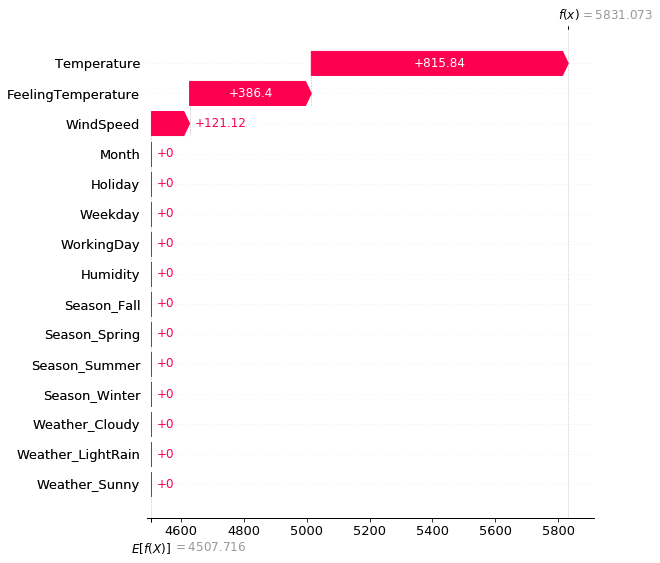

In [21]:
# Predict for single instances
i = 1
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, 
                                       shap_values[i,:], 
                                       feature_names = X_test.columns.values,
                                       max_display = 20
                                       )

In [22]:
shap.force_plot(base_value = explainer.expected_value, 
                shap_values = shap_values[i], 
                features = X_test.iloc[i,:],
                feature_names = X_test.columns.tolist()
                )

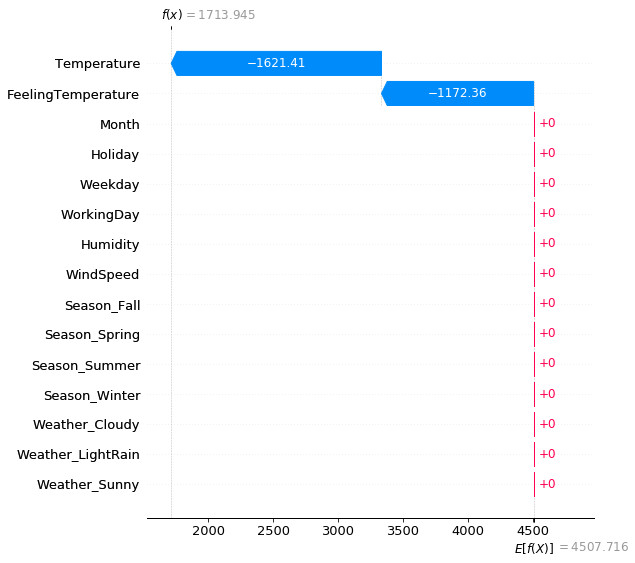

In [23]:
# Predict for single instances
i = 10
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, 
                                       shap_values[i,:], 
                                       feature_names = X_test.columns.values,
                                       max_display = 20
                                       )

In [24]:
shap.force_plot(base_value = explainer.expected_value, 
                shap_values = shap_values[i], 
                features = X_test.iloc[i,:],
                feature_names = X_test.columns.tolist()
                )

In [25]:
# Predict for many instances
shap.force_plot(base_value = explainer.expected_value, 
                shap_values = shap_values[:10], 
                features = X_test.iloc[:10,:],
                feature_names = X_test.columns.tolist()
                )

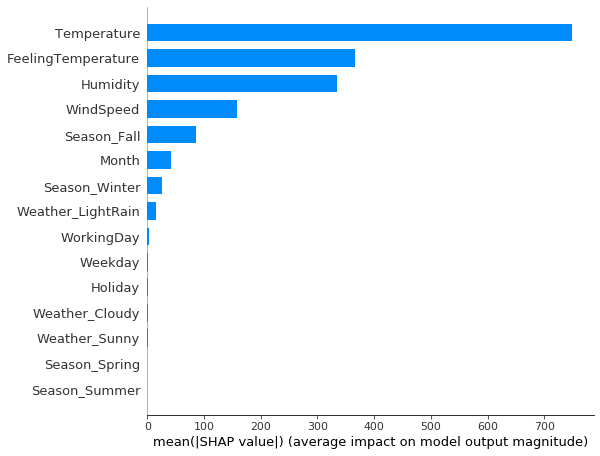

In [26]:
# Get summary plot
shap.summary_plot(shap_values = shap_values, 
                  features = X_test,
                  feature_names = X_test.columns.tolist(),
                  plot_type = "bar"
                  )

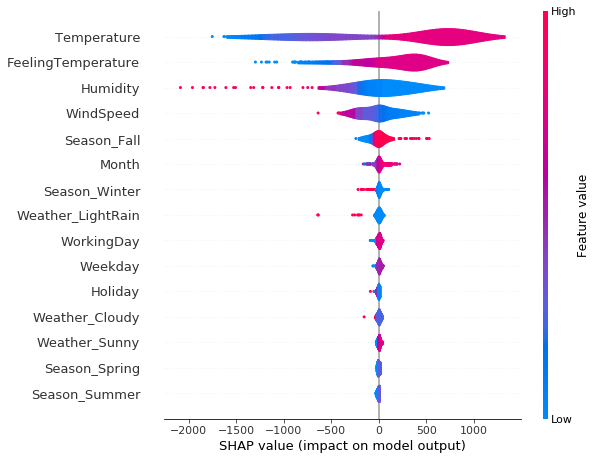

In [27]:
# Get summary plot
shap.summary_plot(shap_values = shap_values, 
                  features = X_test,
                  feature_names = X_test.columns.tolist(),
                  plot_type = "violin"
                  )

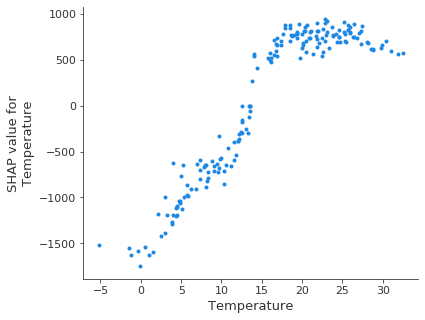

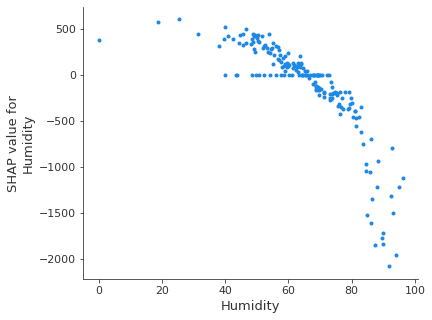

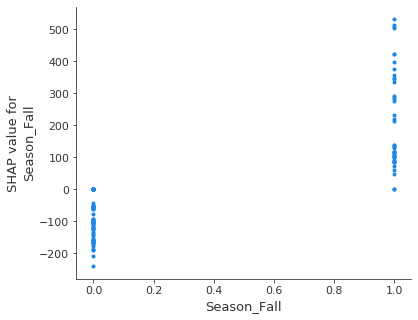

In [28]:
# Get some dependence plots
for i, var in enumerate(['Temperature','Humidity','Season_Fall']):
    shap.dependence_plot(ind = var, 
                         shap_values = shap_values, 
                         features = X_test, 
                         feature_names = X_test.columns, 
                         interaction_index = None
                         )

## Global Surrogate Models

In [29]:
def surrogate_model_linear(model, X_train, X_test):
    # Get predictions from the original model
    y_train = model.predict(X_train)
    y_test  = model.predict(X_test)
    
    # Initiate and train the linear model
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    # Compute weights
    df_weights = pd.DataFrame({'Feature' : X_train.columns, 'Weight' : lr.coef_})

    # Compute effects
    df_effects = np.multiply(X, df_weights.iloc[:,1])

    # Plot weights
    plt.figure(figsize = (10, 5))
    sns.barplot(x = 'Feature', y = 'Weight', data = df_weights)
    plt.title('Weights of Linear Model - ($R^2$={:.2f})'.format(lr.score(X_test, y_test)), fontsize = 20)
    plt.xlabel('')
    plt.ylabel('Weigth', fontsize = 16)
    plt.xticks(rotation = 90)
    plt.show()

    # Plot effects
    plt.figure(figsize = (10, 5))
    sns.boxplot(data = df_effects)
    plt.title('Effects of Linear Model - ($R^2$={:.2f})'.format(lr.score(X_test, y_test)), fontsize = 20)
    plt.xlabel('', fontsize = 16)
    plt.ylabel('Effect', fontsize = 16)
    plt.xticks(rotation = 90)
    plt.show()

In [30]:
def surrogate_model_tree(model, X_train, X_test):
    # Get predictions from the original model
    y_train = model.predict(X_train)
    y_test  = model.predict(X_test)
    
    # Initiate and train the model
    dtr = DecisionTreeRegressor(max_depth = 3)
    dtr.fit(X_train, y_train)

    # Compute importances
    df_importances = pd.DataFrame({'Feature' : X.columns, 'Importance' : dtr.feature_importances_})
    df_importances = df_importances.sort_values(by = 'Importance')

    # Plot structure
    plt.figure(figsize = (10, 5))
    plot_tree(dtr)
    plt.title('Structure of Decission Tree - ($R^2$={:.2f})'.format(dtr.score(X_test, y_test)), fontsize = 20)
    plt.show()

    # Plot importances
    plt.figure(figsize = (10, 5))
    sns.barplot(x = 'Feature', y = 'Importance', data = df_importances)
    plt.title('Feature Importances of Decision Tree - ($R^2$={:.2f})'.format(dtr.score(X_test, y_test)), fontsize = 20)
    plt.xlabel('', fontsize = 16)
    plt.ylabel('Relative Importance', fontsize = 16)
    plt.xticks(rotation = 90)
    plt.show()

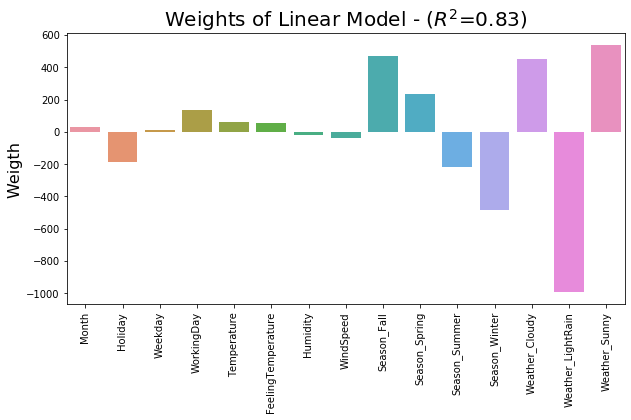

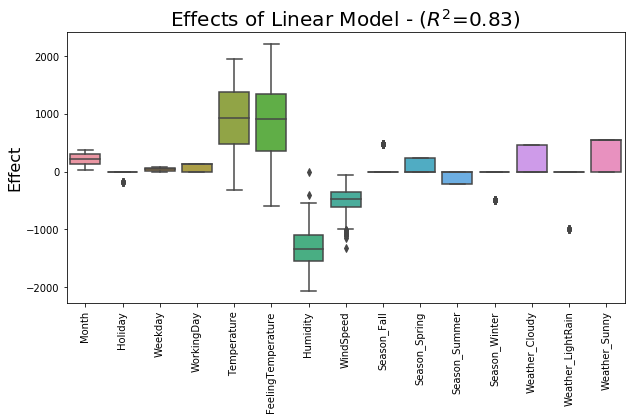

In [31]:
surrogate_model_linear(rfr, X_train, X_test)

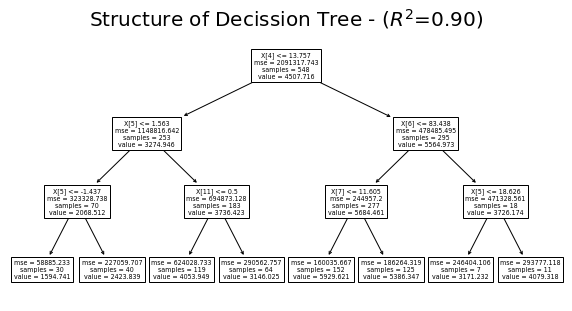

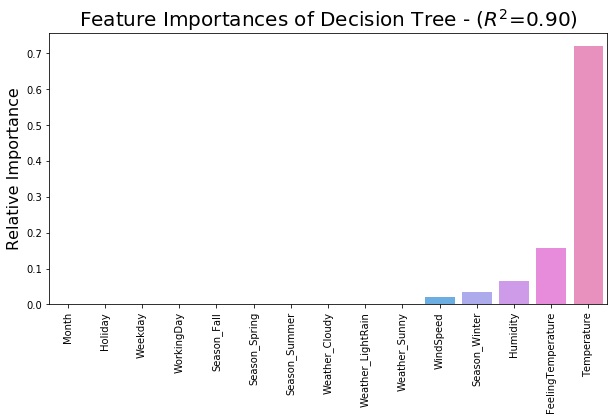

In [32]:
surrogate_model_tree(rfr, X_train, X_test)

## LIME

This library includes modules for computing LIME explanations for various types of data, but we are interested only in the case of tabular data: 
* **lime.lime_tabular.LimeTabularExplainer**: Explains predictions on tabular (i.e. matrix) data. For numerical features, perturb them by sampling from a Normal(0,1) and doing the inverse operation of mean-centering and scaling, according to the means and stds in the training data. For categorical features, perturb by sampling according to the training distribution, and making a binary feature that is 1 when the value is the same as the instance being explained.
    * *training_data*: numpy 2d array.
    * *mode*: “classification” or “regression”.
    * *training_labels*: labels for training data. Not required, but may be used by discretizer.
    * *feature_names*: list of names (strings) corresponding to the columns in the training data.
    * *categorical_features*: list of indices (ints) corresponding to the categorical columns. Everything else will be considered continuous. Values in these columns MUST be integers.
    * *categorical_names*: map from int to list of names, where categorical_names\[x\]\[y\] represents the name of the yth value of column x.
    * *kernel_width* – kernel width for the exponential kernel.  If None, defaults to sqrt (number of columns) * 0.75.
    * *verbose*: if true, print local prediction values from linear model.
    * *class_names*: list of class names, ordered according to whatever the classifier is using. If not present, class names will be ‘0’, ‘1’, ...
    * *feature_selection*: feature selection method. can be ‘forward_selection’, ‘lasso_path’, ‘none’ or ‘auto’. See function ‘explain_instance_with_data’ in lime_base.py for details on what each of the options does.
    * *discretize_continuous*: if True, all non-categorical features will be discretized into quartiles.
    * *discretizer*: only matters if discretize_continuous is True. Options are ‘quartile’, ‘decile’ or ‘entropy’.
    
so once the explanations are computed and saved in a explainer object, we can use the *explain_instance* method for generating a graphic report of the explanation for an instance. Each explainer has its particular methods with some slightly different parameters:
* **explain_instance** (lime.lime_tabular.LimeTabularExplainer): Generates explanations for a prediction. First, we generate neighborhood data by randomly perturbing features from the instance (see __data_inverse). We then learn locally weighted linear models on this neighborhood data to explain each of the classes in an interpretable way (see lime_base.py).
    * *data_row*: 1d numpy array, corresponding to a row
    * *predict_fn*: prediction function. For classifiers, this should be a function that takes a numpy array and outputs prediction probabilities. For regressors, this takes a numpy array and returns the predictions. For ScikitClassifiers, this is classifier.predict_proba(). For ScikitRegressors, this is regressor.predict().
    * *labels*: iterable with labels to be explained.
    * *top_labels*: if not None, ignore labels and produce explanations for the K labels with highest prediction probabilities, where K is this parameter.
    * *num_features*: maximum number of features present in explanation
    * *num_samples*: size of the neighborhood to learn the linear model
    * *distance_metric*: the distance metric to use for weights.
    * *model_regressor*: sklearn regressor to use in explanation. Defaults to Ridge regression in LimeBase. Must have model_regressor.coef_ and ‘sample_weight’ as a parameter to model_regressor.fit()

In [33]:
# Get feature names
feature_names = X.columns.tolist()
categorical_features = [i for i, col in enumerate(X_train.columns) if ('_' in col)]

# Create explainer
explainer = LimeTabularExplainer(np.array(X_train), 
                                 feature_names = feature_names, 
                                 class_names = ['Target'], 
                                 categorical_features = categorical_features, 
                                 verbose = True, 
                                 mode = 'regression')

# Explain some instance prediction
i = 1
display(X_test.iloc[i])
exp = explainer.explain_instance(np.array(X_test)[i], rfr.predict, num_features=5)
exp.show_in_notebook(show_table = True)
html = exp.as_html()
for x in exp.as_list():
    print(x)

Month                  7.000000
Holiday                0.000000
Weekday                3.000000
WorkingDay             1.000000
Temperature           27.250000
FeelingTemperature    29.333486
Humidity              65.125000
WindSpeed             10.666400
Season_Fall            0.000000
Season_Spring          0.000000
Season_Summer          1.000000
Season_Winter          0.000000
Weather_Cloudy         0.000000
Weather_LightRain      0.000000
Weather_Sunny          1.000000
Name: 187, dtype: float64

Intercept 4275.565870962072
Prediction_local [5719.27301124]
Right: 5831.073163999408


('Temperature > 22.83', 1036.5128792960204)
('FeelingTemperature > 24.23', 487.3555858723428)
('Season_Fall=0', -337.63115305426106)
('8.92 < WindSpeed <= 12.13', 129.5864017970293)
('Season_Winter=0', 127.88342636282978)


In [34]:
i = 10
display(X_test.iloc[i])
exp = explainer.explain_instance(np.array(X_test)[i], rfr.predict, num_features=5)
exp.show_in_notebook(show_table = True)
html = exp.as_html()
for x in exp.as_list():
    print(x)

Month                  2.000000
Holiday                0.000000
Weekday                3.000000
WorkingDay             1.000000
Temperature           -1.215644
FeelingTemperature    -6.129832
Humidity              43.739100
WindSpeed             14.869645
Season_Fall            0.000000
Season_Spring          0.000000
Season_Summer          0.000000
Season_Winter          1.000000
Weather_Cloudy         0.000000
Weather_LightRain      0.000000
Weather_Sunny          1.000000
Name: 40, dtype: float64

Intercept 5280.342666767012
Prediction_local [2965.39763527]
Right: 1713.9454753105476


('Temperature <= 7.54', -1434.3046780821642)
('FeelingTemperature <= 5.85', -942.7515725267183)
('Humidity <= 50.88', 561.8214292002687)
('Season_Fall=0', -341.6166216112157)
('12.13 < WindSpeed <= 15.72', -158.09358847523714)
